# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***FEATURE ENGINEERING***

In [1]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, pandas_profiling, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind
from fancyimpute import KNN

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, cvxopt, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from imblearn.over_sampling import SMOTE

# visualization tools
import matplotlib.pyplot as plt, qgrid, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# View tab (Taken from Martin: https://stackoverflow.com/users/2575273/martin)
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))
files = os.listdir(os.curdir)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")
print(os.getcwd())

# only get warnings once
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)

# # toggle on/off code!
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Using TensorFlow backend.


/Users/home/Desktop/Research/Tylenol/Analysis


# **1. Read in Data**
We follow the same data prep steps for the questionnaires, but we won't test any differences in emotion ratings across demographic and psychographic conditions. We'll leave that to the regression analysis.

In [2]:
inducedLong = pd.read_csv('inducedLong.csv')
perceivedLong = pd.read_csv('perceivedLong.csv')

questionnaires = pd.read_csv('Fixed Questionnaires.csv')
print("original questionnaires shape:", questionnaires.shape)

View(questionnaires.head(2).T)

original questionnaires shape: (262, 64)


### Missing Data

In [3]:
# examine
null = pd.DataFrame(questionnaires.isnull().mean()*100)
View(null)

# drop rows where there's no ID or drug/placebo information
questionnaires = questionnaires.dropna(subset=['SubjectID', 'DrugCode', 'DrugPlacebo'], how='any')

print("new questionnaires shape:", questionnaires.shape, "\n")
null = pd.DataFrame(questionnaires.isnull().mean()*100)
View(null)
    # new questionnaires shape: (250, 64)
    
# look at columns with missing values
notnull = null[null[0] != 0]
print(len(notnull), "columns contain null values \n")

# which columns have > 10% missing? drop them.
missing = null[null[0] >= 10]
delete = list(missing.index)
print("these columns have more than 10% of their values as null/missing:")
print(delete, "\n")
    
questionnaires = questionnaires.drop(delete, axis=1)
print("final questionnaires shape:", questionnaires.shape)
View(pd.DataFrame(questionnaires.isnull().sum()))

new questionnaires shape: (250, 64) 

59 columns contain null values 

these columns have more than 10% of their values as null/missing:
['WhenLastExerciseHrs', 'MedsInfo', 'MarijuanaInSystem', 'CigarettesInSystem', 'OMSI'] 

final questionnaires shape: (250, 59)


### Check for duplicates

In [4]:
questionnaires = questionnaires.rename(columns={"SubjectID": "FixedID"})

# Check max ID number
maxid = int(questionnaires['FixedID'].max())
    
# make dataframe checking the number of people per questionnaire
participants = pd.DataFrame()
participants['Potential'] = pd.Series(range(1, maxid+1))
participants = participants.set_index('Potential')
participants['Questionnaire'] = questionnaires[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])

# where are the errors? there should only be one person per questionnaire
qError = list(participants[participants['Questionnaire'] > 1].index)
print("questionnaire errors in participants: ", qError, "\n")

View(questionnaires[questionnaires['FixedID'].isin(qError)])

# delete all IDs who are in error
    # it must be due to some kind mistake with the Qualtrics entries
drop = questionnaires[questionnaires['FixedID'].isin(qError)].index
questionnaires.drop(drop, inplace=True)

# check
print("fixed questionnaires shape:", questionnaires.shape, "\n")

participants['QuestionnaireFixed'] = questionnaires[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
qErrorCheck = list(participants[participants['QuestionnaireFixed'] > 1].index)
print("questionnaires errors in stimuli: ", qErrorCheck, "\n")
View(participants)

questionnaire errors in participants:  [91, 92, 117, 144, 193] 

fixed questionnaires shape: (240, 59) 

questionnaires errors in stimuli:  [] 



# **2. Imputation of Missing Values**
Before we can run a regression analysis, we need to perform some standard feature engineering, such as imputation of missing values, the creation of a single dataframe, and eliminating erroneous data.

In order to tell how we should impute the missing values with the least amount of bias, we need to plot the features that include missing data. The steps are as follows:
1. Find the columns that contain missing data
2. Look at the distributions of these columns
3. Impute using the appropriate method based on the distribution type of the data.

## **2a. Induced Emotion Ratings**
### Graph Features

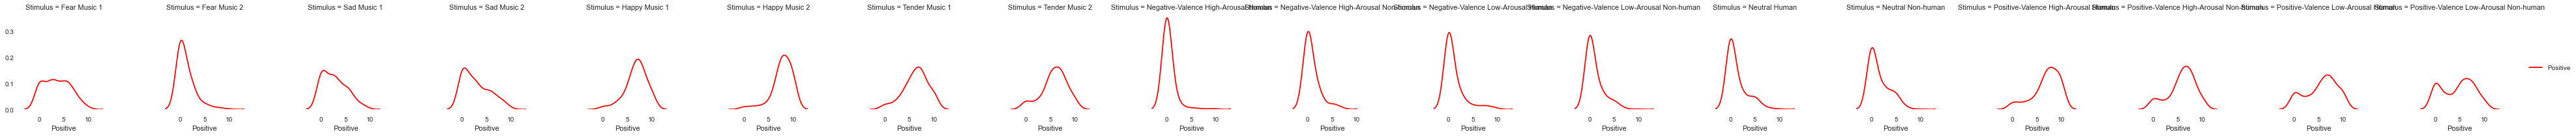

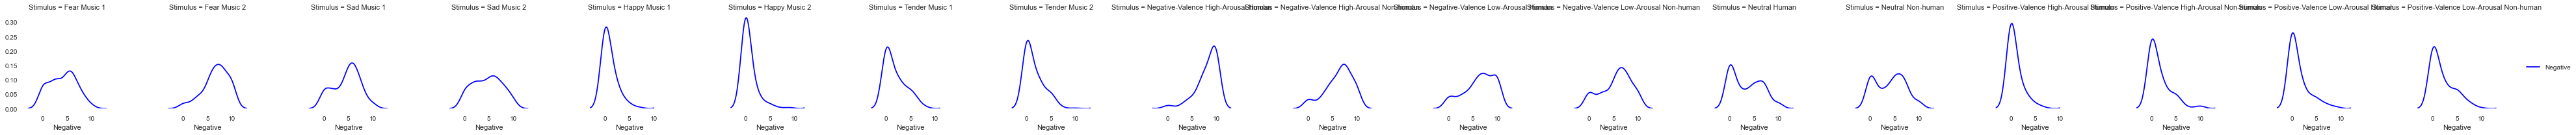

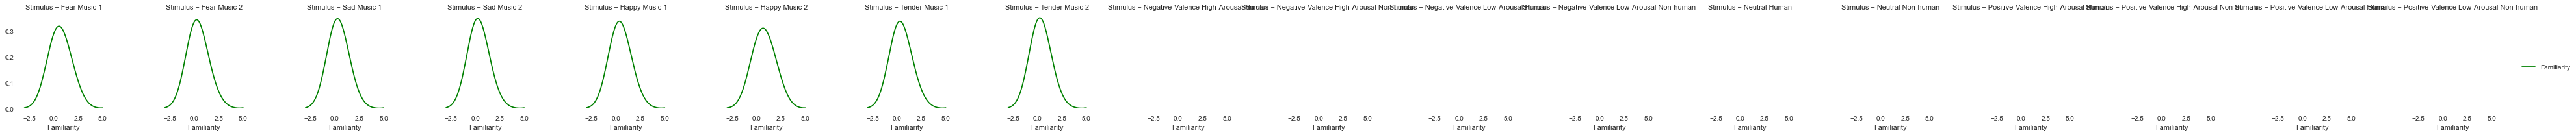

In [5]:
View(pd.DataFrame(inducedLong.isnull().sum()))
    
# look at distributions to see if we should impute by mean or median
g = sns.FacetGrid(inducedLong, col="Stimulus")
g.map(sns.distplot, "Positive", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "red", label = "Positive")
g.add_legend();

g = sns.FacetGrid(inducedLong, col="Stimulus")
g.map(sns.distplot, "Negative", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "blue", label = "Negative")
g.add_legend();

g = sns.FacetGrid(inducedLong, col="Stimulus")
g.map(sns.distplot, "Familiarity", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "green", label = "Familiarity")
g.add_legend();

*(Note that it was an intentional choice of the researchers to avoid taking familiarity ratings for the natural sounds stimuli)*


**Because the data are skewed, it's best to use the median for imputation purposes.**

**We'll impute the values based on their closest neighbors--namely, we'll use the median rating of the feature for *each individual stimulus* to avoid bias.**

### Impute.

In [6]:
### impute missing values based on neighbors ###
# median is best for all three
View(inducedLong.groupby(['Stimulus'])['Positive', 'Negative', 'Familiarity'].median())

# impute missing values with median values for the same feature (e.g., Positive) and stimulus (e.g., Fear Music 1)

colList = ['Positive', 'Negative', 'Familiarity']
for i, column in enumerate(colList):
    inducedLong[column] = inducedLong.groupby(["Stimulus"], sort = False)[column].apply(lambda x: x.fillna(x.median()))

# check and reset index
View(pd.DataFrame(inducedLong.isnull().mean()*100))

inducedLong.reset_index(inplace = True, drop = True) 

## **2b. Perceived Emotion Ratings**
We repeat the same process for the perceived emotion ratings.

### Graph Features

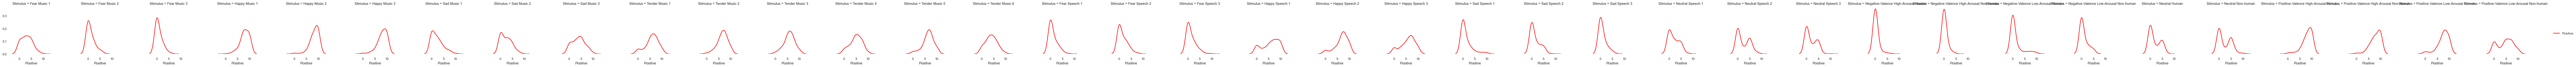

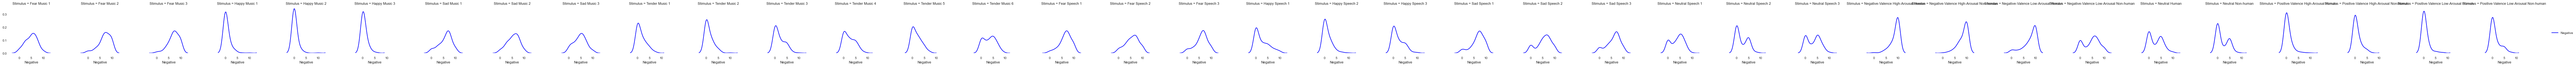

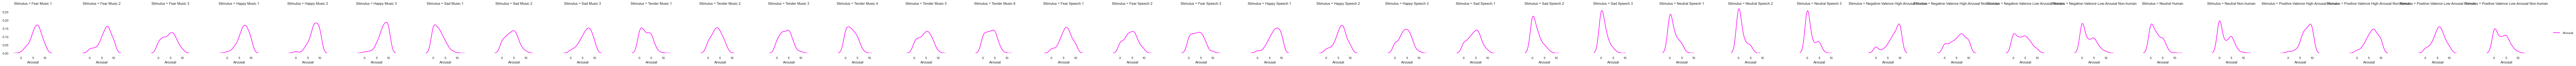

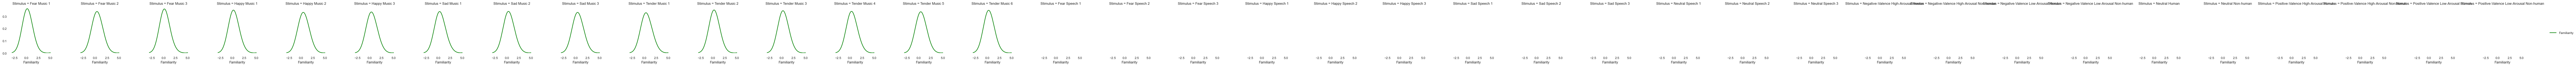

In [7]:
View(pd.DataFrame(perceivedLong.isnull().sum()))

# look at distributions to see if we should impute by mean or median
g = sns.FacetGrid(perceivedLong, col="Stimulus")
g.map(sns.distplot, "Positive", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "red", label = "Positive")
g.add_legend();

g = sns.FacetGrid(perceivedLong, col="Stimulus")
g.map(sns.distplot, "Negative", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "blue", label = "Negative")
g.add_legend();

g = sns.FacetGrid(perceivedLong, col="Stimulus")
g.map(sns.distplot, "Arousal", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "magenta", label = "Arousal")
g.add_legend();

g = sns.FacetGrid(perceivedLong, col="Stimulus")
g.map(sns.distplot, "Familiarity", hist = False, norm_hist = True, kde_kws={"bw":1}, color = "green", label = "Familiarity")
g.add_legend();

**Once again, we'll impute the values based on their closest neighbors--namely, we'll use the median rating of the feature for *each individual stimulus* to avoid bias.**
### Impute

In [8]:
### impute missing values based on neighbors ###
# median is best for all four
View(perceivedLong.groupby(['Stimulus'])['Positive', 'Negative', 'Arousal', 'Familiarity'].median())

# impute missing values with median values for the same feature (e.g., Positive) and stimulus (e.g., Fear Music 1)

colList = ['Positive', 'Negative', 'Arousal', 'Familiarity']
for i, column in enumerate(colList):
    perceivedLong[column] = perceivedLong.groupby(["Stimulus"], sort = False)[column].apply(lambda x: x.fillna(x.median()))

# check and reset index
View(pd.DataFrame(perceivedLong.isnull().mean()*100))

perceivedLong.reset_index(inplace = True, drop = True) 

## **2c. Combine dataframes**
Now we need to create a single dataframe for the regression analysis.

In [9]:
# check shapes
print("perceivedLong shape:", perceivedLong.shape)
print("inducedLong shape:", inducedLong.shape)
print("questionnaires shape:", questionnaires.shape, "\n")

# make sure column names are the same for perceived and induced (both already long)
print(perceivedLong.columns == inducedLong.columns, "\n")

# perceived and induced -- just need to rbind
pi = pd.concat([perceivedLong, inducedLong])
print("perceived/induced shape:", pi.shape), "\n"
View(pi.sample(5))

# combine perceived/induced with questionnaires
long = pi.merge(questionnaires, on=['FixedID', 'DrugCode', 'DrugPlacebo'], how='left')
print("long shape:", long.shape)
View(long.sample(20))

perceivedLong shape: (8880, 35)
inducedLong shape: (4338, 35)
questionnaires shape: (240, 59) 

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True] 

perceived/induced shape: (13218, 35)
long shape: (13218, 91)


### Double check about duplicates or participant ID numbers

In [10]:
participants = pd.DataFrame()
participants['Potential'] = pd.Series(range(1, 281))
participants = participants.set_index('Potential')
participants['Perceived'] = perceivedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
participants['Induced'] = inducedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
participants['Questionnaire'] = questionnaires[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
participants['P/I'] = pi[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
participants['Long'] = long[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
participants['CheckPI'] = participants['Perceived'] + participants['Induced'] == participants['P/I']
participants['CheckLong'] = participants['P/I'] == participants['Long']
View(participants)

# check to see why they are false
participants.loc[(participants.CheckPI == False) | (participants.CheckLong == False)]

View(participants)
View(pd.DataFrame(long['FixedID'].value_counts()))

**All of the data seem to be okay! The only data that are still missing are due to:**
* ID numbers in my hypothetical list that didn't correspond to any real participant ID
* Participants who only completed one block of the study (perceived emotion or induced emotion) but not the other one (technical errors, left early, etc.)
* People who completed the pre-test questionnaires but did not complete either stimulus block (perceived or induced emotion). These cases were dropped, as their data won't help the analysis.

# **3. Feature Engineering**
Many of the features--especially in the questionnaire data--need to be transformed before they can be used in any statistical analysis. Some of the categorical columns should be coded on an ordinal, instead of nominal, scale. Others contain messy data that need to be cleaned up using regular expressions. 

*In this section, we will use **feature engineering** to perform the necessary tasks to produce a suitable dataframe for analysis.*

In [11]:
model = long.replace("Not Measured", np.nan)
numericCols = list(model.columns[(model.dtypes.values != np.dtype('object'))])
categoricalCols = list(model.columns[(model.dtypes.values == np.dtype('object'))])

print("shape of model dataframe: ", model.shape)
print("number of numeric columns: ", len(numericCols))
print("number of categorical columns: ", len(categoricalCols))
print("number of numeric + categorical columns: ", len(numericCols) + len(categoricalCols))

shape of model dataframe:  (13218, 91)
number of numeric columns:  65
number of categorical columns:  26
number of numeric + categorical columns:  91


We can see here that the dataframe currently has 65 numeric columns and 26 categorical columns. We will deal with the numeric columns first, follwed by the categorical columns.

## **3a. Numeric Column Wrangling**
The FixedID column (the participant IDs) are currently numeric. Since the "difference" between persons 1 and 2 should be the same as between persons 1 and 244, the feature should be categorical rather than numeric.

### Turn IDs into a Categorical Variable

In [12]:
# participants are not ordered in any way
model['FixedID'] = model['FixedID'].astype(str)

## **3b. Categorical Column Wrangling**
**There are several different ways we need to transform the categorical features. Below, we will perform the following operations:**
* Drop theoretically redundant features
* Re-label binary variables as 0 and 1
* Convert ordinal variables from nominal Likert scales to numeric values (e.g., 1-7)
* Transforming uncategorized variables (that require unique transformations)
* One-hot encode certain nominal variables

First, we will examine the unique values in each categorical column.

In [13]:
# for i, column in enumerate(categoricalCols):
#     print(column, "unique values:")
#     print(model[column].unique(), "\n")

### Drop Redundant Features
Features that are theoretically identical to another feature should be dropped from the analysis, in order to prevent multicollinearity.

#### *DrugCode*

In [14]:
# DrugCode gives the exact same info as the FixedID column 
dropCols = ['DrugCode']
model = model.drop(columns=dropCols)
model.shape

(13218, 90)

### Binary Variables
Variables with only two values (for example, ***Yes*** vs. ***No*** responses) should be recoded as 0 and 1.

#### *Locus (Perceived Emotion vs. Induced Emotion)*

In [15]:
#print(model.Locus.value_counts(normalize=True).round(2)*100)
model.Locus = model.Locus.replace(to_replace=['Perceived','Induced'], value=[0, 1])

#### *TakeMedsRecentlyYN*

In [16]:
#print(model.TakeMedsRecentlyYN.value_counts(normalize=True).round(2)*100)
model.TakeMedsRecentlyYN = model.TakeMedsRecentlyYN.replace(to_replace=['no','yes'], value=[0, 1])

#### *BirthControlYN*

In [17]:
#print(model.BirthControlYN.value_counts(normalize=True).round(2)*100)
model.BirthControlYN = model.BirthControlYN.replace(to_replace=['no','yes'], value=[0, 1])

#### *ArthritisYN*

In [18]:
#print(model.ArthritisYN.value_counts(normalize=True).round(2)*100)
model.ArthritisYN = model.ArthritisYN.replace(to_replace=['no','yes'], value=[0, 1])

#### *ImmuneDisordersYN*

In [19]:
#print(model.ImmuneDisordersYN.value_counts(normalize=True).round(2)*100)
model.ImmuneDisordersYN = model.ImmuneDisordersYN.replace(to_replace=['no','yes'], value=[0, 1])

#### *EndocrineDisordersYN*

In [20]:
#print(model.EndocrineDisordersYN.value_counts(normalize=True).round(2)*100)
model.EndocrineDisordersYN = model.EndocrineDisordersYN.replace(to_replace=['no','yes'], value=[0, 1])

#### *DiabeticYN*

In [21]:
#print(model.DiabeticYN.value_counts(normalize=True).round(2)*100)
model.DiabeticYN = model.DiabeticYN.replace(to_replace=['no','yes, type 1'], value=[0, 1])

### Ordinal Variables
**Variables on Likert scales should be recoded as ordinal values, as there is an inherent order to these responses.**


For example, for the question ***When you take Tylenol, how effective is it at reducing your pain?***, the possible responses were: 
* I have never taken Tylenol
* Not effective at all
* Slightly effective
* Moderately effective
* Very effective
* Extremely effective

In this case, we can see that ***Not effective at all*** is less than ***Slightly effective***, and, in turn, ***Slightly effective*** is less than ***Moderately effective*** and so on. By transforming these variables to ordinal, we can capture this difference in any statistical analysis. 

Without recoding, it would be difficult to compare ***Extremely effective*** vs. ***Not effective at all***, for instance.

#### *MedsEffectiveness*

In [22]:
#print(model.MedsEffectiveness.unique())
model.MedsEffectiveness = model.MedsEffectiveness.replace(to_replace=['never taken', 'not at all', 'almost never', 'slightly',
                                                                     'moderately', 'very', 'extremely'], 
                                                          value=[1, 2, 3, 4, 5, 6, 7])


#### *Politics*

In [23]:
#print(model.Politics.unique())
model.Politics = model.Politics.replace(to_replace=['very liberal', 'liberal', 'somewhat liberal', 'moderate',
                                                    'somewhat conservative', 'conservative', 'very conservative'], 
                                        value=[1, 2, 3, 4, 5, 6, 7])

#### *HowMuchLastEat*

In [24]:
#print(model.HowMuchLastEat.unique())
model.HowMuchLastEat = model.HowMuchLastEat.replace(to_replace=['snack', 'light meal', 'full meal'], value=[1, 2, 3])


#### *CigarettesPerDay*

In [25]:
#print(model.CigarettesPerDay.unique())
model.CigarettesPerDay = model.CigarettesPerDay.replace(to_replace=['0', '1-10', '11-20'], value=[1, 2, 3])


#### *FrequencyTakeMeds*

In [26]:
#print(model.FrequencyTakeMeds.unique())
model.FrequencyTakeMeds = model.FrequencyTakeMeds.replace(to_replace=['never taken', 'less than once a year', 
                                                                      'at least once a year', 'several times a year',
                                                                      'at least once a month', 'several times a month', 
                                                                      'at least once a week', 'several times a week',
                                                                      'almost everyday'], 
                                                          value=[1, 2, 3, 4, 5, 6, 7, 8, 9])


#### *WhenLastSick*

In [27]:
#print(model.WhenLastSick.unique())
model.WhenLastSick = model.WhenLastSick.replace(to_replace=['a year or more ago', 'a few months ago', 
                                                            'a month ago', 'a couple of weeks ago',
                                                            'a week ago', 'a couple of days ago', 'today'], 
                                                value=[1, 2, 3, 4, 5, 6, 7])



#### *MarijuanaFrequency*

In [28]:
#print(model.MarijuanaFrequency.unique())
model.MarijuanaFrequency = model.MarijuanaFrequency.replace(to_replace=['never', 'at least once a year', 
                                                                        'several times a year', 'at least once a month',
                                                                        'several times a month', 'at least once a week', 
                                                                        'several times a week', 'almost every day'], 
                                                            value=[1, 2, 3, 4, 5, 6, 7, 8])


#### *YearUniversity*

In [29]:
#print(model.YearUniversity.unique())
model.YearUniversity = model.YearUniversity.replace(to_replace=['None', '1', '2', '3', '4', '5'], value=[np.nan, 1, 2, 3, 4, 5])

### Transforming Uncategorized Variables
There are additional variables that do not fit any of these categories that we need to transform.

#### *Russell --> HighLow*

In [30]:
#print("Russell unique values: \n", model.Russell.value_counts(normalize=True).round(2)*100, "\n")

# Change into an arousal column (high arousal/low arousal/neutral) to prevent multicollinearity with the PosNeg feature
model['HighLow'] = model.Russell.replace(to_replace=['Neg-Valence High-Arousal', 'Pos-Valence High-Arousal', 
                                                     'Neg-Valence Low-Arousal', 'Pos-Valence Low-Arousal', 'Neutral'], 
                                         value=["High", "High", "Low", "Low", "Neutral"])

# drop original column
model = model.drop(['Russell'], axis=1)

#print("HighLow unique values: \n", model.HighLow.value_counts(normalize=True).round(2)*100)

#### *PreferredMeds*

In [31]:
# Reduce categories
#print(model.PreferredMeds.value_counts(normalize=True).round(2)*100)

model.PreferredMeds = model.PreferredMeds.replace(to_replace=['Ibuprofen', 'Acetaminophen', 'Unknown', 'More Than One Type',
                                                              'Naproxen Sodium', 'Do Not Take Meds ', 'Acetylsalicylic Acid', 
                                                              "Pseudoephedrine Hydrochloride", "Calcium Carbonate", 
                                                              "Baclofen", "Marijuana"], 
                                                  value=["Ibuprofen", "Acetaminophen", "Other", "Other", "Other",
                                                         "None", "Other", "Other", "Other", "Other", "Other"])


#### *LastAlcoholDays*

In [32]:
#print(model.LastAlcoholDays.unique())

# Get rid of "Never"
model['LastAlcoholDays'] = pd.to_numeric(model['LastAlcoholDays'], errors='coerce')

### One-Hot Encoding of Nominal Variables

In [33]:
# # Stimulus
# print("Stimulus: ", model.Stimulus.unique(), "\n")

# # PosNeg
# print("PosNeg: ", model.PosNeg.unique(), "\n")

# # HighLow
# print("HighLow: ", model.HighLow.unique(), "\n")

# # SoundType
# print("SoundType: ", model.SoundType.unique(), "\n")

# # Gender
# print("Gender: ", model.Gender.unique(), "\n")

# # PoliticalParty
# print("PoliticalParty: ", model.PoliticalParty.unique(), "\n")

# # PreferredMeds
# print("PreferredMeds: ", model.PreferredMeds.unique(), "\n")

# # Race
# print("Race: ", model.Race.unique())

model = pd.get_dummies(model, columns=['Stimulus', 'PosNeg', 'HighLow', 'SoundType', 'Gender', 'PoliticalParty', 'PreferredMeds', 'Race'])

#### *Race*
Instead of having separate categories for one-hot encoded multiple racial identities, like ***White and Hispanic***, we will transform these columns so that if a person identifies with a single race, the value will be ***1*** and if they do not, the value will be ***0***. 

So, each person will have the following one-hot encoded variables:
* Race_Asian
* Race_Black
* Race_Hispanic
* Race_Other
* Race_White

If a person identifies as ***Asian***, they will have the following values:
* ***Race_Asian = 1***
* Race_Black = 0
* Race_Hispanic = 0
* Race_Other = 0
* Race_White = 0

If a person identifies as ***White and Asian***, they will have the following values:
* ***Race_Asian = 1***
* Race_Black = 0
* Race_Hispanic = 0
* Race_Other = 0
* ***Race_White = 1***

In [34]:
### race transformation -- recode multiple races into single race columns ###
for i, row in model.iterrows():
    
    # Race_Black and Hispanic
    if model.loc[i, 'Race_Black and Hispanic'] == 1:
        
        # Adding count (1) to Race_Black if it is at 0 -- otherwise keep the '1' (don't want '2s')
        if model.loc[i, 'Race_Black'] == 0:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black'] + 1
        else:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black']
        
        # Adding count (1) to Race_Hispanic if it is at 0 -- otherwise keep the '1' (don't want '2s')
        if model.loc[i, 'Race_Hispanic'] == 0:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic'] + 1
        else:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic']
            
    # Race_Black and Other
    if model.loc[i, 'Race_Black and Other'] == 1:
        
        # Adding count (1) to Race_Black if it is at 0
        if model.loc[i, 'Race_Black'] == 0:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black'] + 1
        else:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black']
        
        # Adding count (1) to Race_Other if it is at 0
        if model.loc[i, 'Race_Other'] == 0:
            model.loc[i, 'Race_Other'] = model.loc[i, 'Race_Other'] + 1
        else:
            model.loc[i, 'Race_Other'] = model.loc[i, 'Race_Other']
    
    # Race_Hispanic and Asian
    if model.loc[i, 'Race_Hispanic and Asian'] == 1:
        
        # Adding count (1) to Race_Hispanic if it is at 0
        if model.loc[i, 'Race_Hispanic'] == 0:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic'] + 1
        else:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic']
        
        # Adding count (1) to Race_Asian if it is at 0
        if model.loc[i, 'Race_Asian'] == 0:
            model.loc[i, 'Race_Asian'] = model.loc[i, 'Race_Asian'] + 1
        else:
            model.loc[i, 'Race_Asian'] = model.loc[i, 'Race_Asian']
            
    # Race_White and Asian
    if model.loc[i, 'Race_White and Asian'] == 1:
        
        # Adding count (1) to Race_White if it is at 0
        if model.loc[i, 'Race_White'] == 0:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White'] + 1
        else:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White']
        
        # Adding count (1) to Race_Asian if it is at 0
        if model.loc[i, 'Race_Asian'] == 0:
            model.loc[i, 'Race_Asian'] = model.loc[i, 'Race_Asian'] + 1
        else:
            model.loc[i, 'Race_Asian'] = model.loc[i, 'Race_Asian']
            
    # Race_White and Black
    if model.loc[i, 'Race_White and Black'] == 1:
        
        # Adding count (1) to Race_White if it is at 0
        if model.loc[i, 'Race_White'] == 0:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White'] + 1
        else:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White']
        
        # Adding count (1) to Race_Black if it is at 0
        if model.loc[i, 'Race_Black'] == 0:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black'] + 1
        else:
            model.loc[i, 'Race_Black'] = model.loc[i, 'Race_Black']
            
    # Race_White and Hispanic
    if model.loc[i, 'Race_White and Hispanic'] == 1:
        
        # Adding count (1) to Race_White if it is at 0
        if model.loc[i, 'Race_White'] == 0:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White'] + 1
        else:
            model.loc[i, 'Race_White'] = model.loc[i, 'Race_White']
        
        # Adding count (1) to Race_Hispanic if it is at 0
        if model.loc[i, 'Race_Hispanic'] == 0:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic'] + 1
        else:
            model.loc[i, 'Race_Hispanic'] = model.loc[i, 'Race_Hispanic'] 

model = model.drop(columns=['Race_Black and Hispanic', 'Race_Black and Other', 'Race_Hispanic and Asian', 
                            'Race_White and Asian', 'Race_White and Black', 'Race_White and Hispanic'])   
        
# # check
# colList = ['Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White']
# for column in colList:
#     print("---- %s ---" % column)
#     print(model[column].value_counts(normalize=True).round(2)*100, "\n")

#### *LastTimeTookMeds*
This column is very messy. 
* There are nonsensical values, like *15 NA* and *_years*. 
* There are also values on all different scales, like *>1 years*, *215 days*, and *5 minutes*.

**Here, we will transform the values so that the LastTimeTookMeds values are all measured in *days*.**

In [35]:
#print("before transformation: ", model.LastTimeTookMeds.unique(), "\n")

# replace unhelpful characters
model['LastTimeTookMeds'] = model['LastTimeTookMeds'].str.replace(">|NA", "")
model['LastTimeTookMeds'] = model['LastTimeTookMeds'].replace(r'^.*NA.*$', np.nan, regex=True)

# replace uncertainties with a nan
model['LastTimeTookMeds'] = model['LastTimeTookMeds'].str.replace("unknown|never", "")

# replace beginning whitespace (e.g., ' months') with 1 (e.g., '1 months')
model['LastTimeTookMeds'] = model['LastTimeTookMeds'].replace(r'^ .*', '1' + model['LastTimeTookMeds'].astype(str), regex=True)

# separate numbers and text
model[['LastTimeTookMeds_Num','LastTimeTookMeds_Text']] = model['LastTimeTookMeds'].str.split(expand=True)
model['LastTimeTookMeds_Num'] = model['LastTimeTookMeds_Num'].astype(float)

### change to days for now ###
model['LastTimeTookMeds'] = model['LastTimeTookMeds_Num']

# minute
minute = model[model['LastTimeTookMeds_Text'].str.contains('minute') == True].index
model.loc[minute,'LastTimeTookMeds'] = model.loc[minute,'LastTimeTookMeds_Num']/1440

# hour
hour = model[model['LastTimeTookMeds_Text'].str.contains('hour') == True].index
model.loc[hour,'LastTimeTookMeds'] = model.loc[hour,'LastTimeTookMeds_Num']/24

# week
week = model[model['LastTimeTookMeds_Text'].str.contains('week') == True].index
model.loc[week,'LastTimeTookMeds'] = model.loc[week,'LastTimeTookMeds_Num']*7

# month
month = model[model['LastTimeTookMeds_Text'].str.contains('month') == True].index
model.loc[month,'LastTimeTookMeds'] = model.loc[month,'LastTimeTookMeds_Num']*30

# year
year = model[model['LastTimeTookMeds_Text'].str.contains('year') == True].index
model.loc[year,'LastTimeTookMeds'] = model.loc[year,'LastTimeTookMeds_Num']*365

model = model.drop(columns=['LastTimeTookMeds_Text', 'LastTimeTookMeds_Num'])

#print("after transformation: ", model.LastTimeTookMeds.unique())
    
model.head(5)

,FixedID,DrugPlacebo,Locus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,MedsEffectiveness,LastTimeTookMeds,FrequencyTakeMeds,Politics,ChildSES,AdultSES,Height,Weight,SleepHours,WhenLastAte,HowMuchLastEat,SleepQuality,IllnessSeverity,exerciseMinToday,ExerciseRegularMins,LastConsumeCaffeineHours,GeneralHealth,SubjectiveIllness,WhenLastSick,NumDoctorVisits,TakeMedsRecentlyYN,BirthControlYN,MarijuanaFrequency,CigarettesPerDay,LastAlcoholDays,AlcoholAvg,ArthritisYN,ImmuneDisordersYN,EndocrineDisordersYN,DiabeticYN,Age,YearUniversity,NeedToBelong,Nostalgia,EarlyFamilyEnvironment,PosPANAS,NegPANAS,Mellow,Unpretentious,Sophisticated,Intense,Contemporary,PT,FS,EC,PD,E,A,C,N,O,AIMS,Stimulus_Fear Music 1,Stimulus_Fear Music 2,Stimulus_Fear Music 3,Stimulus_Fear Speech 1,Stimulus_Fear Speech 2,Stimulus_Fear Speech 3,Stimulus_Happy Music 1,Stimulus_Happy Music 2,Stimulus_Happy Music 3,Stimulus_Happy Speech 1,Stimulus_Happy Speech 2,Stimulus_Happy Speech 3,Stimulus_Negative-Valence High-Arousal Human,Stimulus_Negative-Valence High-Arousal Non-human,Stimulus_Negative-Valence Low-Arousal Human,Stimulus_Negative-Valence Low-Arousal Non-human,Stimulus_Neutral Human,Stimulus_Neutral Non-human,Stimulus_Neutral Speech 1,Stimulus_Neutral Speech 2,Stimulus_Neutral Speech 3,Stimulus_Positive-Valence High-Arousal Human,Stimulus_Positive-Valence High-Arousal Non-human,Stimulus_Positive-Valence Low-Arousal Human,Stimulus_Positive-Valence Low-Arousal Non-human,Stimulus_Sad Music 1,Stimulus_Sad Music 2,Stimulus_Sad Music 3,Stimulus_Sad Speech 1,Stimulus_Sad Speech 2,Stimulus_Sad Speech 3,Stimulus_Tender Music 1,Stimulus_Tender Music 2,Stimulus_Tender Music 3,Stimulus_Tender Music 4,Stimulus_Tender Music 5,Stimulus_Tender Music 6,PosNeg_Negative,PosNeg_Neutral,PosNeg_Positive,HighLow_High,HighLow_Low,HighLow_Neutral,SoundType_Music,SoundType_Natural Sounds,SoundType_Speech,Gender_female,Gender_male,Gender_prefer not to answer,PoliticalParty_democrat,PoliticalParty_libertarian,PoliticalParty_other,PoliticalParty_republican,PreferredMeds_Acetaminophen,PreferredMeds_Do Not Take Meds,PreferredMeds_Ibuprofen,PreferredMeds_Other,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,8.0,1,0,3.0,5.0,7.0,0.0,0,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,NaN,NaN,0,4.0,1460.0,6.0,6.0,5.333333,3.333333,66.0,142.0,7.0,1.0,1.0,7.0,1.875,45.0,540.0,168.0,4.0,1.666667,2.0,1.0,1.0,0.0,1.0,1.0,5.0,1.666667,0.0,0.0,0.0,0.0,18.0,1.0,35.0,6.428571,1.769231,12.0,11.0,5.000000,6.000000,4.285714,3.25,4.75,3.285714,2.714286,3.142857,1.571429,3.250,4.222222,4.000000,2.125,3.5,77.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,4.0,1,0,3.0,6.0,9.0,0.0,0,NaN,0,0,2,2,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,NaN,NaN,0,1.0,3650.0,1.0,3.0,5.333333,6.000000,71.0,168.0,10.0,1.0,3.0,8.0,1.125,0.0,270.0,1.0,3.0,1.666667,1.0,0.0,0.0,0.0,7.0,1.0,5.0,3.000000,0.0,0.0,0.0,0.0,18.0,1.0,40.0,2.428571,3.769231,20.0,12.0,3.333333,2.000000,2.714286,3.75,4.75,2.000000,2.000000,2.571429,1.857143,3.875,2.555556,3.333333,2.875,3.3,102.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,6.0,1,0,2.0,8.0,10.0,0.0,0,NaN,0,0,1,1,0,0,2,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,NaN,NaN,0,5.0,365.0,5.0,3.0,6.000000,4.333333,72.0,205.0,9.0,1.0,1.0,10.0,1.625,20.0,300.0,24.0,2.0,1.333333,2.0,0.0,0.0,0.0,8.0,1.0,4.0,2.333333,0.0,0.0,0.0,0.0,19.0,2.0,45.0,5.000000,2.538462,17.0,35.0,5.333333,3.666667,4.857143,5.75,6.50,1.142857,3.142857,2.571429,2.000000,3.500,3.333333,2.333333,3.500,3.8,151.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,7.0,0,0,3.0,3.0,8.0,1.0,0,NaN,0,0,2,1,0,0,1,NaN,NaN,Na

### Check Transformations

In [36]:
model.reset_index(inplace = True, drop = True)
numericCols = list(model.columns[(model.dtypes.values != np.dtype('object'))])
categoricalCols = list(model.columns[(model.dtypes.values == np.dtype('object'))])
print("shape of model dataframe: ", model.shape)
print("number of numeric columns: ", len(numericCols))
print("number of categorical columns: ", len(categoricalCols), "\nlist of cat columns = ", categoricalCols)

shape of model dataframe:  (13218, 144)
number of numeric columns:  143
number of categorical columns:  1 
list of cat columns =  ['FixedID']


**Now, 143 of the 144 features are numeric! The only one that is still categorical is FixedID. We can now proceed with the statistical analysis and exploratory data analysis.**

## **3c. Plot**
The next step is to make graphs of the distributions of the variables to see if we need to transform them in any other way.

There are 143 features to plot.


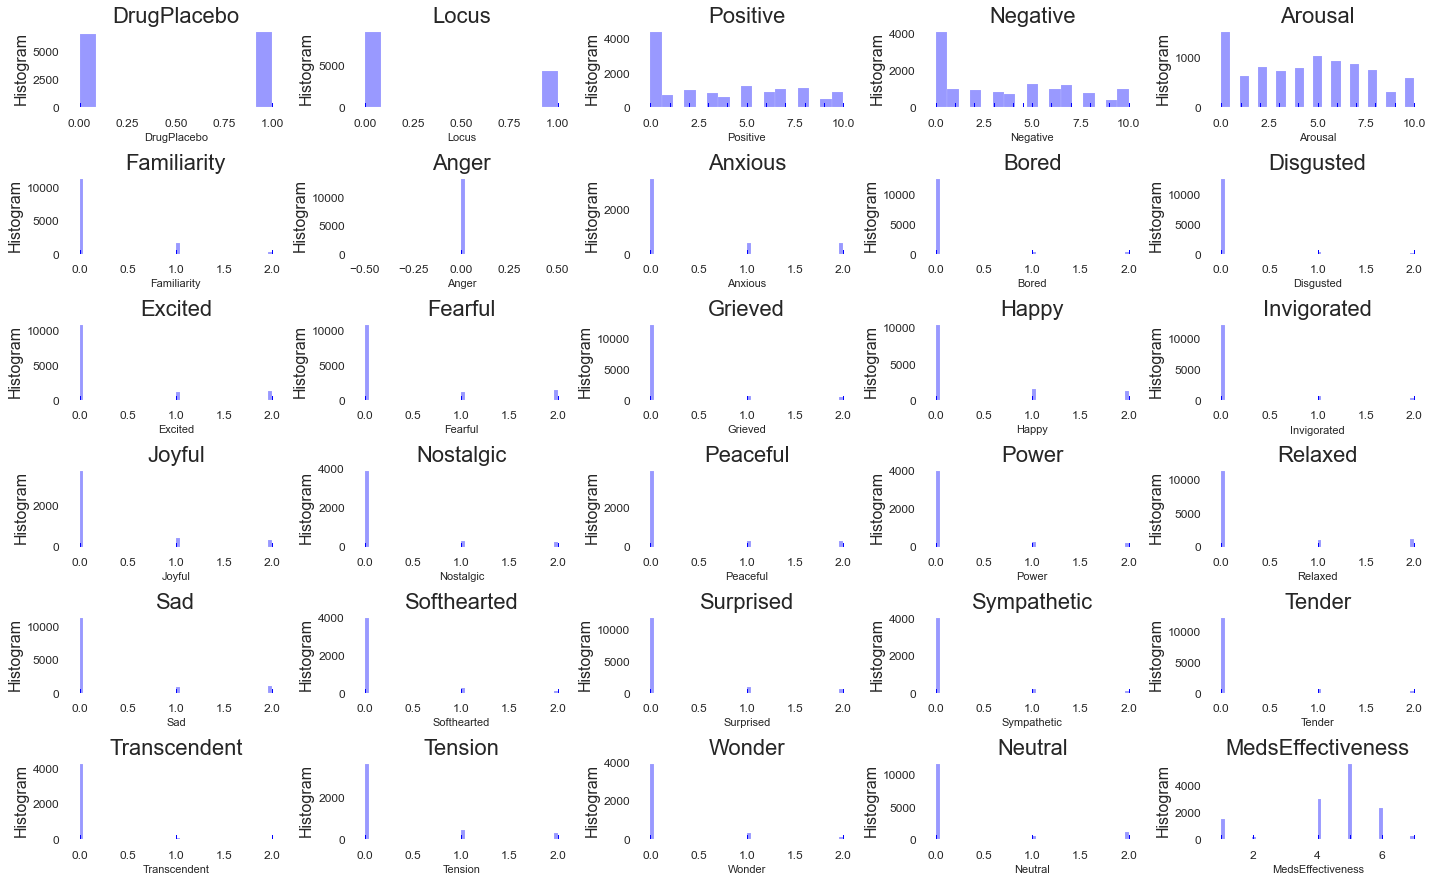

In [37]:
colList = list(model.columns)
colList.remove('FixedID')
print("There are", len(colList), "features to plot.")

plt.figure(figsize=(20,20))
for i, column in enumerate(colList[0:30]):
    plt.subplot(10, 5, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**The three emotion ratings (positive, negative, arousal) are right skewed.**
* We'll try transforming these later on.

**People don't seem to rate any of the specific emotions highly.** 
* We'll come back to this in the last part of the analysis.

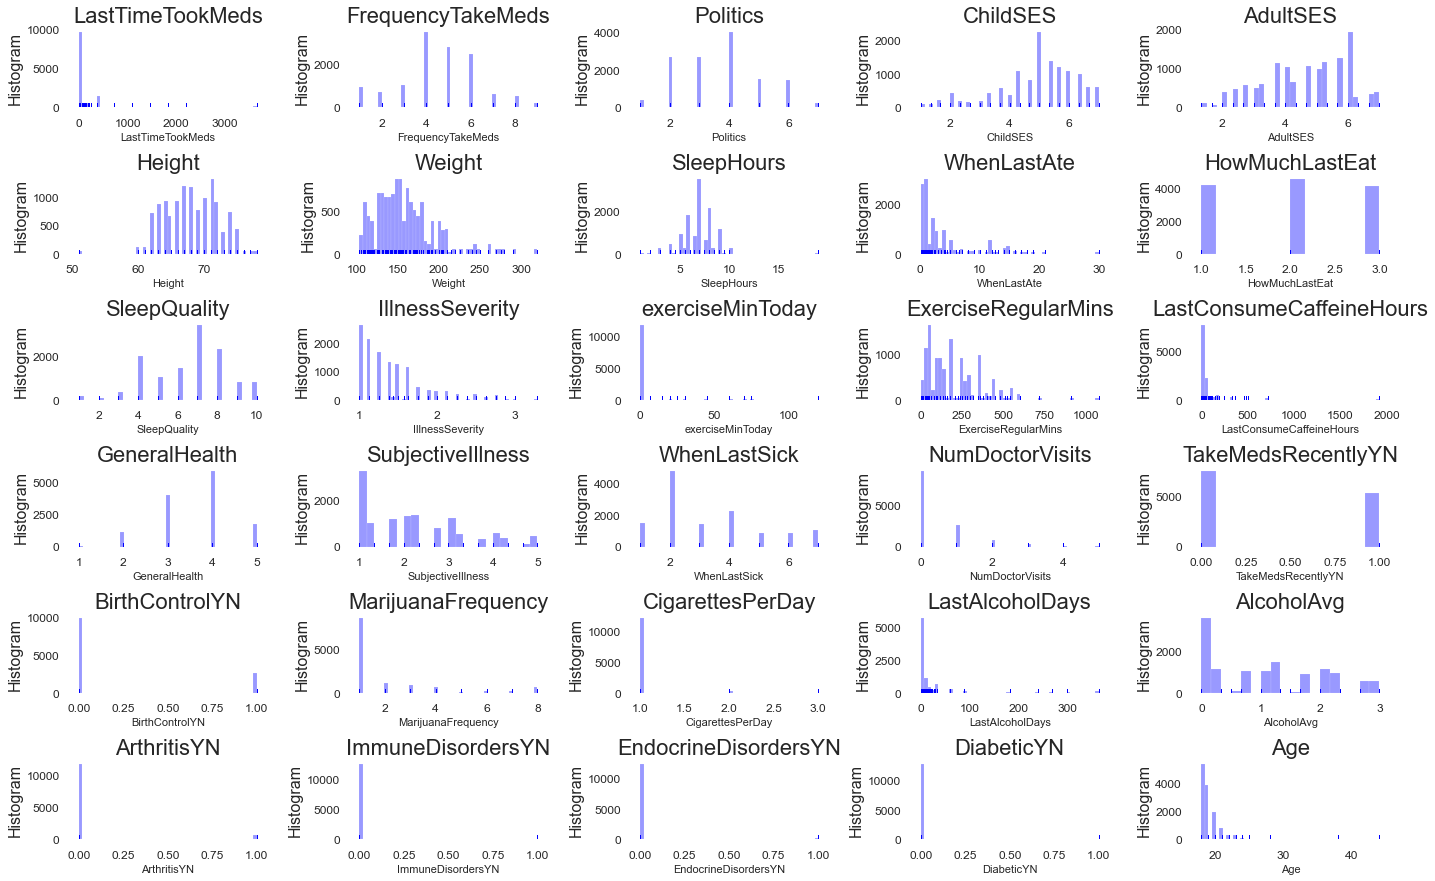

In [38]:
plt.figure(figsize=(20,20))
for i, column in enumerate(colList[30:60]):
    plt.subplot(10, 5, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**Some variables seem to have little variance, like *DiabeticYN* and *CigarettesPerDay*.**
* We'll look for outliers and variability in the next step.

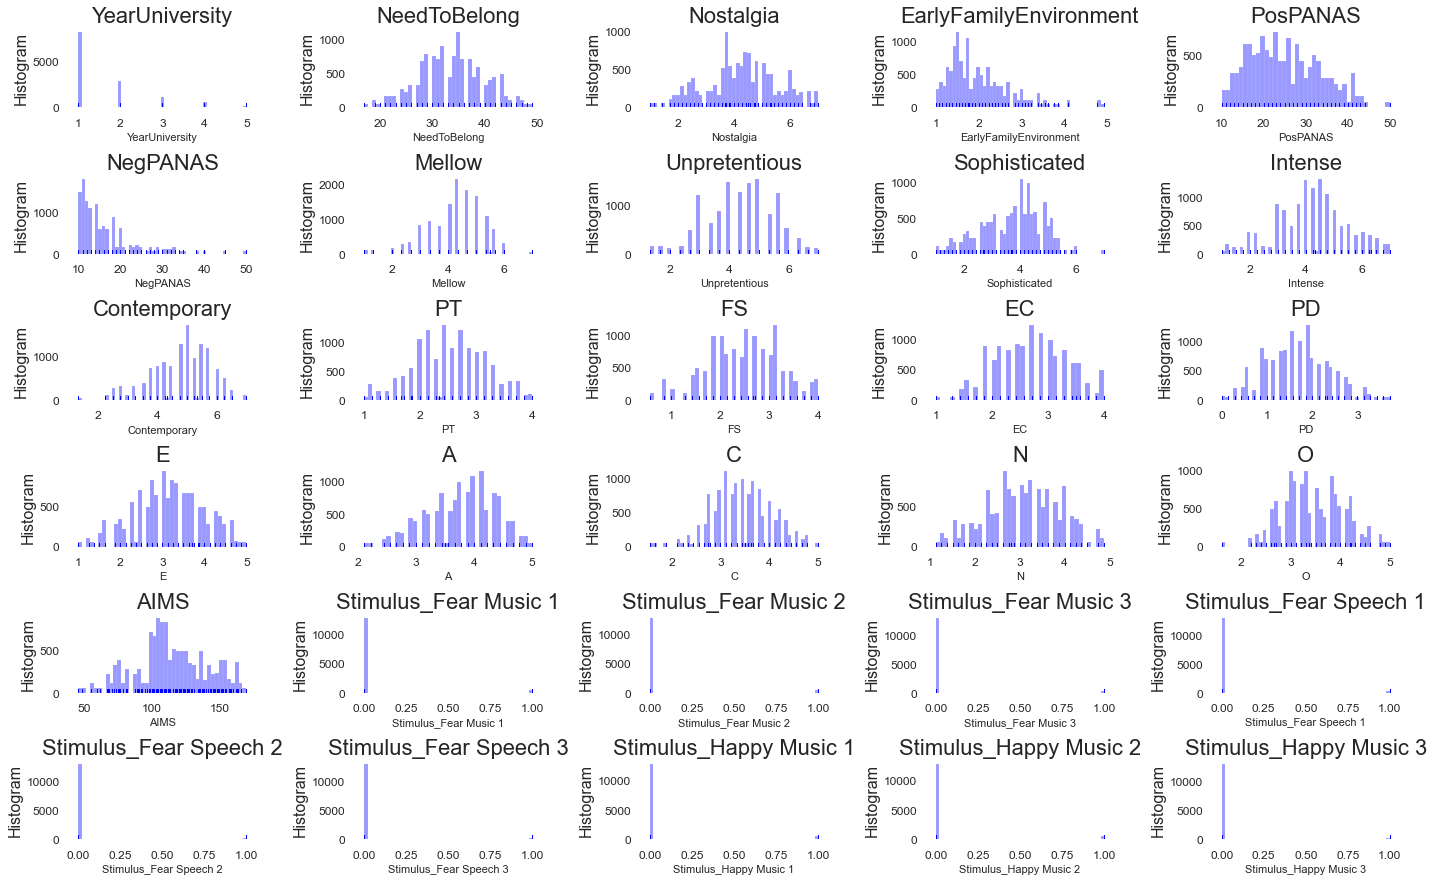

In [39]:
plt.figure(figsize=(20,20))
for i, column in enumerate(colList[60:90]):
    plt.subplot(10, 5, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**The psychographic variables, like *nostalgia*, *empathy* (PT, FS, EC, and PD), *personality* (E, A, C, N, and O), and *absorption in music* (AIMS) look reasonably normally distributed!**

The Stimulus distributions are not useful, as the number of each stimulus was predetermined.

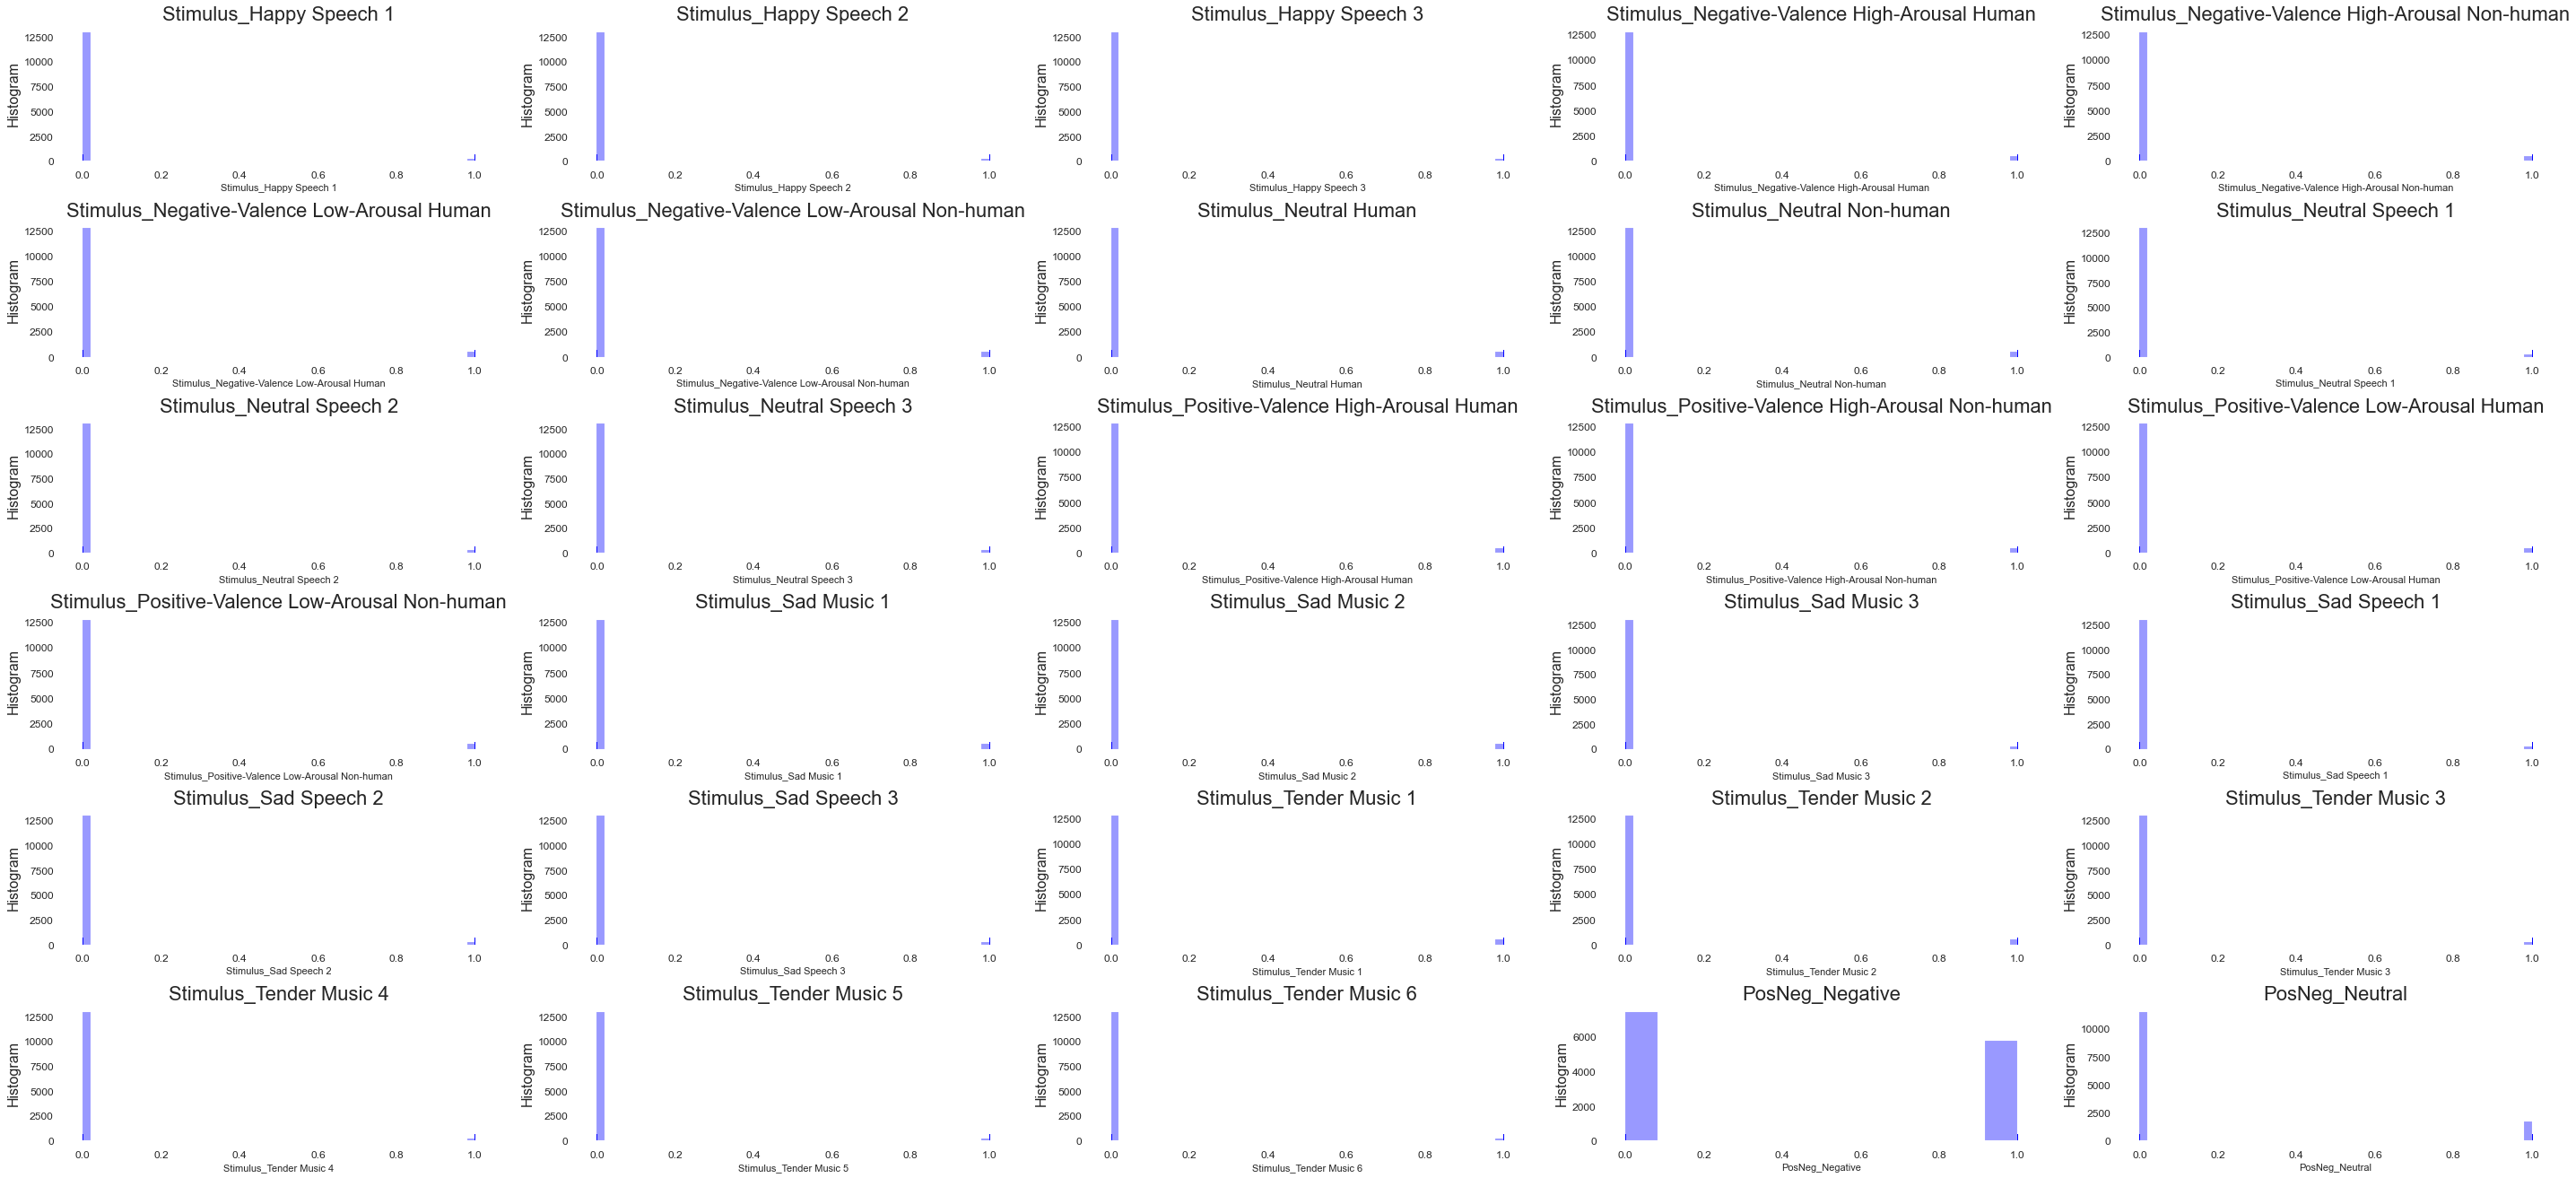

In [40]:
plt.figure(figsize=(40,30))
for i, column in enumerate(colList[90:120]):
    plt.subplot(10, 5, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

As stated above, the Stimulus distributions are not useful, as the number of each stimulus was predetermined.

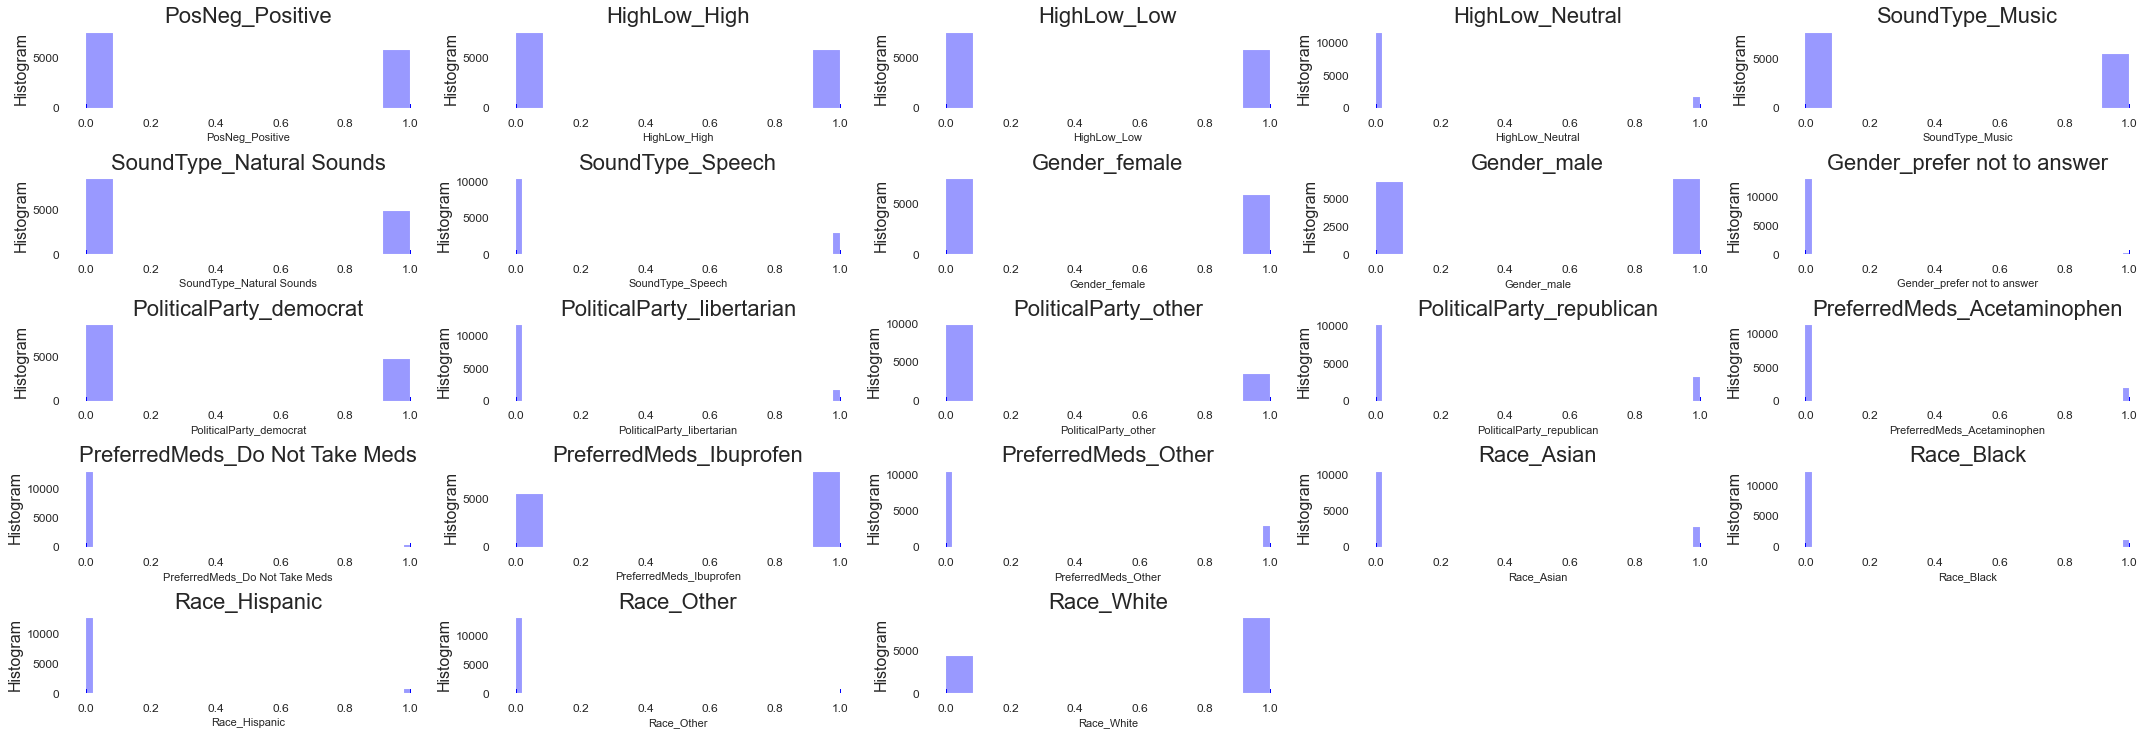

In [41]:
plt.figure(figsize=(30,20))
for i, column in enumerate(colList[120:150]):
    plt.subplot(10, 5, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**Some of the one-hot encoded distributions look skewed**
* We will investigate this more in the next section

## **3d. Feature Selection**
We do not want to include features with a high level of missingness in the model, as imputing these values can lead to bias.

Similarly, features where almost every observation is the same will not inform us about how emotion ratings differ between those who took the drug and those who took the placebo.

**Therefore, we will delete features with high level of missingness and very low variance**

### Look for variables that are missing > 10% of the data

In [42]:
null = pd.DataFrame(model.isnull().mean()*100)
null = null[null[0] > 0]
ten = null[null[0] >= 10]
View(ten)

**Other than the specific emotions (which were not included in both perceived and induced), only 2 features are missing more tan 10% of the data:**
* *Arousal* -- 32.8% missing.
* *LastAlcoholDays* -- 30.9% missing.

The arousal values are missing because participants were not asked to rate arousal for the induced emotion stimuli -- we will therefore keep it in the model as is.

We will delete ***LastAlcoholDays***, though, because of its missingness.


### Look for variables where one response accounts for 95-100% of the variance

In [43]:
# for column in model.columns:
#     test = model[column].value_counts(normalize = True).round(2)*100 >= 95
#     if len(test[test == True]) >=1:
#         print(column)

We want to keep all the one-hot encoded variables and specific emotions for later analysis. 

**However, we will delete the following columns that had only one value for 95-100% of the observations:**
* CigarettesPerDay
* ImmuneDisordersYN
* EndocrineDisordersYN
* DiabeticYN

### Delete

In [44]:
delete = ['LastAlcoholDays', 'CigarettesPerDay', 'ImmuneDisordersYN', 'EndocrineDisordersYN', 'DiabeticYN']
model = model.drop(columns=delete)
print("model shape:", model.shape)    

model shape: (13218, 139)


## **3e. Outlier Detection**
For each feature, we should investigate the percent of outliers present. 

We will define ***outlier*** as **an observation that is more than 3 standard deviations outside of the mean (in either direction).**

In [45]:
colList = list(model.columns)
colList.remove('FixedID')

for i, column in enumerate(colList):
    # find number out outliers in the column
    num = model[model[column] > model[column].mean() + 3 * model[column].std()]
    
    # find the number of participants that contributed to the outliers 
    # (each person's response to the questionnaire is repeated 55 times) 
    people = int(len(num)/55)
    
    # find percent of people (# people/244 total participants) that contributed the outliers
    percent = int(people/244*100)
    if percent >= 5:
        print(column, "\n", percent, "% outliers \n")

Sad 
 7 % outliers 

Neutral 
 8 % outliers 

ArthritisYN 
 5 % outliers 

Race_Black 
 7 % outliers 

Race_Hispanic 
 5 % outliers 



The only non 'one-hot encoded' value or 'specific emotion value' is ***ArthritisYN*** (with 5% of the cases being outliers). We will still keep it in the analysis for now. 

## **3f. Transform Skewed Variables**
Recall that the three emotion ratings (the dependent variables) were right skewed. We will try transforming them to see if that helps the distribution before more normal.

We will use a **log(1+x) transformation**.

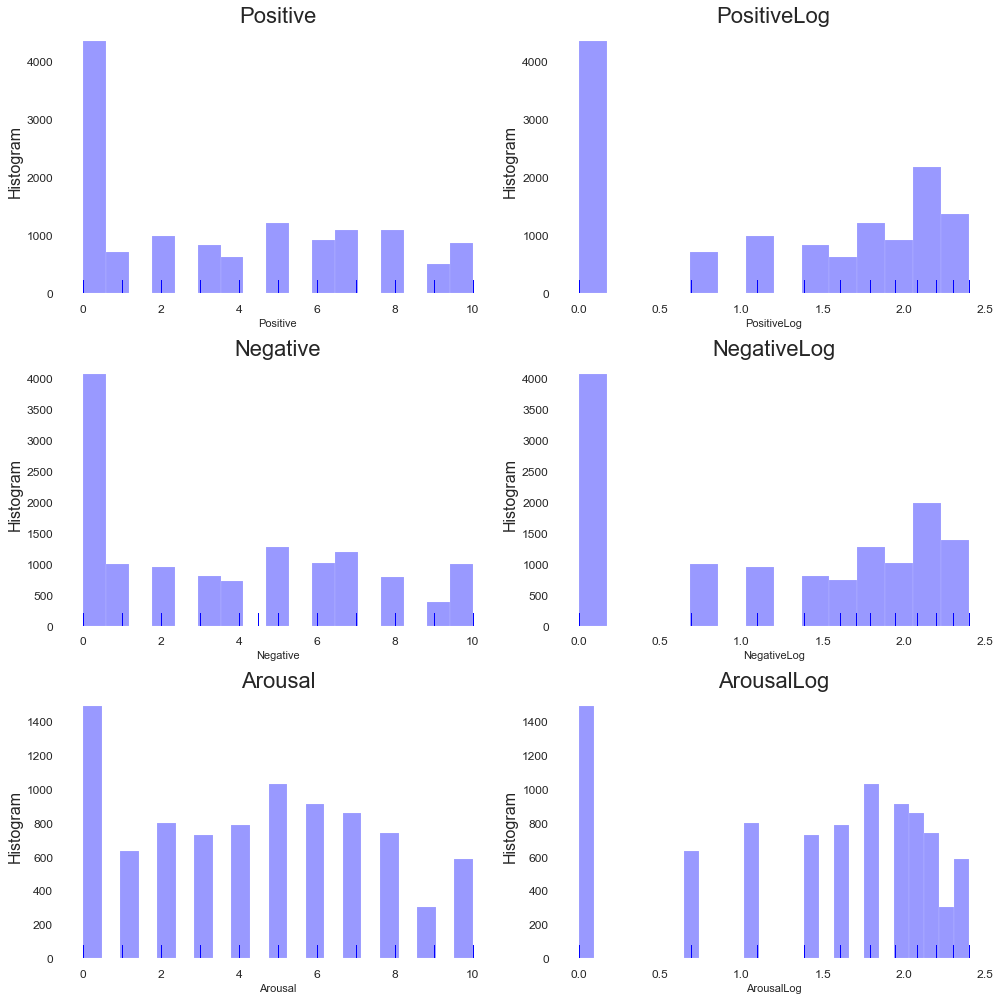

In [46]:
# Positive Emotion Ratings
posLog = np.log(model.Positive + 1)
model['PositiveLog'] = posLog

# Negative Emotion Ratings
negLog = np.log(model.Negative + 1)
model['NegativeLog'] = negLog

# Arousal Ratings
arLog = np.log(model.Arousal + 1)
model['ArousalLog'] = arLog

# Plot
transformed = ['Positive', 'PositiveLog', 'Negative', 'NegativeLog', 'Arousal', 'ArousalLog']
plt.figure(figsize=(14, 14))
for i, column in enumerate(transformed):
    plt.subplot(3, 2, i+1)
    sns.distplot(model[column], hist = True, rug = True, kde = False, color = "b")
    plt.title(column, size = 22)
    plt.ylabel('Histogram', fontsize=16)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# That didn't help -- delete the logged columns
model = model.drop(['PositiveLog', 'NegativeLog', 'ArousalLog'], axis=1)

**The transformation didn't help the skew so we return to the original values to aid in interpretability.**

## **3g. Impute missing values**

There are some new missing values (for example, when people completed the stimuli blocks but not the questionnaires, etc.) We will, once again, impute these missing values with the column median.

As discussed above, we will not impute the ***arousal*** values or the ***specific emotion values*(like Wonder and Sympathetic)**, as these values are missing because of the *a priori* study design.

In [47]:
View(pd.DataFrame(model.isnull().sum()))

# impute columns with missing values with the median for that column
colList = list(model.columns)
colList = [i for i in colList if i not in ('FixedID', 'Arousal')]
emotions = list(model.loc[:, 'Anger':'Neutral'].columns)
colList = [i for i in colList if i not in emotions]
model[colList] = model[colList].apply(lambda x: x.fillna(x.median()))

# check
View(pd.DataFrame(model.isnull().mean()*100))
    # only Arousal and specific emotions are > 0 -- good!

## **3h. Correlations**
We will look for high correlations that may lead to multicollinearity problems.

### Plot

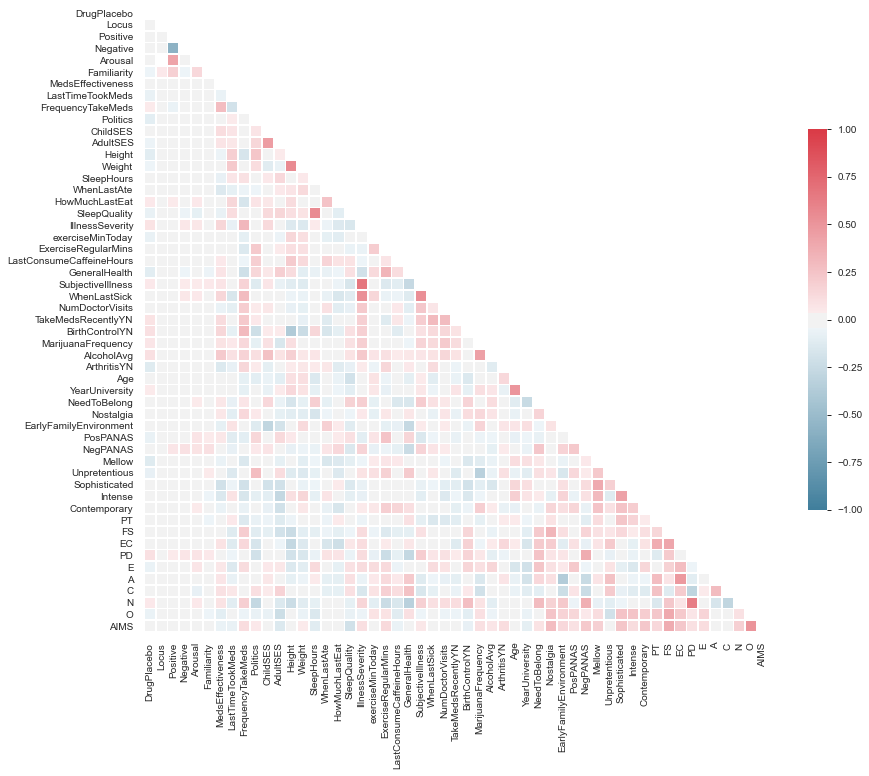

In [48]:
colList = list(model.columns)
colList.remove('FixedID')
colList = [i for i in colList if i not in emotions]

# don't look one-hot encoded values
colList = [ x for x in colList if "_" not in x ]
corr = model[colList].corr()
fig, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = cmap, fmt = '.2g', vmax = 1.0, vmin = -1.0, center = 0, square = True, \
            mask = mask, linewidths = 0.7, cbar_kws = {"shrink": 0.5}, annot = False)

**There are a few high correlations, but the variables seem to be mostly reasonably uncorrelated.**

**We will look for more details, next.**

### List high correlations

In [49]:
cor = model[colList].corr().abs().round(decimals=2)
corNew = cor.unstack()
corNew = corNew[(corNew != 1) & (corNew != 0)]
corNew = corNew.dropna()
corNew = corNew.sort_values(kind="quicksort", ascending = False)
corNew = pd.DataFrame(corNew)

print("maximum absolute value correlation: ", corNew.max()[0])
View(corNew)

maximum absolute value correlation:  0.68


**The highest correlation (absolute value) is 0.68, so we don't have to worry too much about multicollinearity.**

**Regularization (L1) will take care of that if needed.**

## **3i. View final dataframe and reset index**

### Summarize

In [50]:
model = model.sort_values(by=['FixedID'])
model.reset_index(inplace = True, drop = True) 
print("final model shape:", model.shape)
print("number of participants: ", len(model['FixedID'].unique()), "\n")

final model shape: (13218, 139)
number of participants:  244 



**The final dataframe consists of 139 features for 244 participants.**

# Write out CSV

In [51]:
model.to_csv('model.csv', index=False)